# $k$-Nearest Neighbours

## Imports

In [1]:
import sys

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("code/.")

import ipywidgets as widgets
import mglearn
from IPython.display import display
from ipywidgets import interact, interactive
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split
from utils import *

%matplotlib inline

pd.set_option("display.max_colwidth", 200)
import warnings
warnings.filterwarnings("ignore")

### Quick recap

- Why do we split the data? 
- What are the 4 types of data we discussed last class?
- What are the advantages of cross-validation?
- What is overfitting? 
- What's the fundamental trade-off in supervised machine learning? 
- What is the golden rule of machine learning?

## Learning outcomes

From this lecture, you will be able to 

- explain the notion of similarity-based algorithms; 
- broadly describe how $k$-NNs use distances; 
- discuss the effect of using a small/large value of the hyperparameter $k$ when using the $k$-NN algorithm; 

If you want to run this notebook you will have to install `ipywidgets`. 
Follow the installation instructions [here](https://ipywidgets.readthedocs.io/en/latest/user_install.html).

In [2]:
# !conda install -c conda-forge ipywidgets

## Motivation and distances

### Analogy-based models

- Suppose you are given the following training examples with corresponding labels and are asked to label a given test example.

<img src='img/knn-motivation.png' width="1000">

[source](https://vipl.ict.ac.cn/en/database.php)

- An intuitive way to classify the test example is by finding the most "similar" example(s) from the training set and using that label for the test example.  

### Analogy-based algorithms in practice

- [Herta's High-tech Facial Recognition](https://www.hertasecurity.com/en)
    - Feature vectors for human faces 
    - $k$-NN to identify which face is on their watch list
- Recommendation systems     

<img src='img/hetra.png' width="500">

[source](https://hertasecurity.com/)

### General idea of $k$-nearest neighbours algorithm

- Consider the following toy dataset with two classes.
    - blue circles $\rightarrow$ class 0
    - red triangles $\rightarrow$ class 1 
    - green stars $\rightarrow$ test examples

In [3]:
X, y = mglearn.datasets.make_forge()
X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, 0.5]])

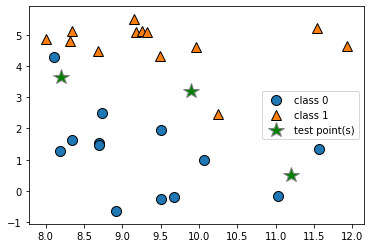

In [4]:
plot_train_test_points(X, y, X_test)

- Given a new data point, predict the class of the data point by finding the "closest" data point in the training set, i.e., by finding its "nearest neighbour" or majority vote of nearest neighbours. 

In [5]:
def f(n_neighbors):
    return plot_knn_clf(X, y, X_test, n_neighbors=n_neighbors)

In [6]:
interactive(f,n_neighbors=widgets.IntSlider(min=1, max=7, step=2, value=1),)

interactive(children=(IntSlider(value=1, description='n_neighbors', max=7, min=1, step=2), Output()), _dom_cla…

### Geometric view of tabular data and dimensions 

- To understand analogy-based algorithms it's useful to think of data as points in a high dimensional space. 
- Our `X` represents the the problem in terms of relevant **features** ($d$) with one dimension for each **feature** (column).
- Examples are **points in a $d$-dimensional space**. 

How many dimensions (features) are there in the cities data?

In [7]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
X_cities = cities_df[["longitude", "latitude"]]
y_cities = cities_df["country"]

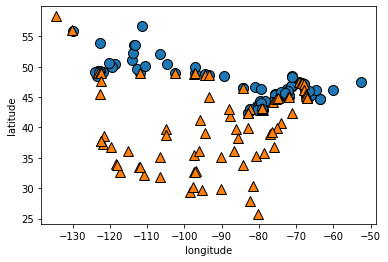

In [8]:
mglearn.discrete_scatter(X_cities.iloc[:, 0], X_cities.iloc[:, 1], y_cities)
plt.xlabel("longitude")
plt.ylabel("latitude");

- Recall the [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset from homework 1. 
- How many dimensions (features) we used in the homework? 

In [9]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target", "song_title", "artist"])
print("The number of features in the Spotify dataset: %d" % X_spotify.shape[1])
X_spotify.head()

The number of features in the Spotify dataset: 13


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


### Dimensions in ML problems 

In ML, usually we deal with high dimensional problems where examples are hard to visualize.  

- $d \approx 20$ is considered low dimensional
- $d \approx 1000$ is considered medium dimensional 
- $d \approx 100,000$ is considered high dimensional 

### Feature vectors 

**Feature vector**
: is composed of feature values associated with an example.

Some example feature vectors are shown below. 

In [10]:
print(f"An example feature vector from the cities dataset: {X_cities.iloc[0].to_numpy()}")
print(f"An example feature vector from the Spotify dataset: \n{X_spotify.iloc[0].to_numpy()}")

An example feature vector from the cities dataset: [-130.0437   55.9773]
An example feature vector from the Spotify dataset: 
[ 1.02000e-02  8.33000e-01  2.04600e+05  4.34000e-01  2.19000e-02
  2.00000e+00  1.65000e-01 -8.79500e+00  1.00000e+00  4.31000e-01
  1.50062e+02  4.00000e+00  2.86000e-01]


### Similarity between examples

Let's take 2 points (two feature vectors) from the cities dataset.

In [11]:
two_cities = X_cities.sample(2, random_state=120)
two_cities

,longitude,latitude
69,-104.8253,38.8340
35,-112.0741,33.4484


The two sampled points are shown as big black circles.

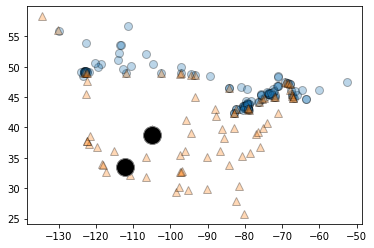

In [12]:
mglearn.discrete_scatter(X_cities.iloc[:, 0], X_cities.iloc[:, 1], y_cities, s=8, alpha=0.3)
mglearn.discrete_scatter(two_cities.iloc[:, 0], two_cities.iloc[:, 1], markers="o", c="k", s=18)

### Distance between feature vectors 

- For the cities at the two big circles, what is the _distance_ between them?
- A common way to calculate the distance between vectors is calculating the **Euclidean distance**. 
- The euclidean distance between vectors $u = <u_1, u_2, \dots, u_n>$ and $v = <v_1, v_2, \dots, v_n>$ is defined as: 

$$distance(u, v) = \sqrt{\sum_{i =1}^{n} (u_i - v_i)^2}$$ 


### Euclidean distance 

In [13]:
two_cities

,longitude,latitude
69,-104.8253,38.8340
35,-112.0741,33.4484


- Subtract the two cities
- Square the difference
- Sum them up 
- Take the square root 

In [14]:
# Subtract the two cities
print(f"Subtract the cities: \n{two_cities.iloc[1] - two_cities.iloc[0]}\n")

# Squared sum of the difference
print(f"Sum of squares: {np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2): 0.4f}")

# Take the square root
print(f"Euclidean distance between cities: {np.sqrt(np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2)): 0.4f}")

Subtract the cities: 
longitude   -7.2488
latitude    -5.3856
dtype: float64

Sum of squares:  81.5498
Euclidean distance between cities:  9.0305


In [15]:
two_cities

,longitude,latitude
69,-104.8253,38.8340
35,-112.0741,33.4484


In [16]:
# Euclidean distance using sklearn
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances(two_cities)

array([[0.        , 9.03049217],
       [9.03049217, 0.        ]])

Note: `scikit-learn` supports a number of other [distance metrics](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).


### Finding the nearest neighbour

- Let's look at distances from all cities to all other cities

In [17]:
dists = euclidean_distances(X_cities)
np.fill_diagonal(dists, np.inf)
dists.shape

(209, 209)

In [18]:
pd.DataFrame(dists)

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,inf,4.955113,9.869531,10.106452,10.449666,19.381676,28.366626,33.283857,33.572105,36.180388,...,9.834455,58.807684,16.925593,56.951696,59.384127,58.289799,64.183423,52.426410,58.033459,51.498562
1,4.955113,inf,14.677579,14.935802,15.305346,24.308448,33.200978,38.082949,38.359992,40.957919,...,14.668787,63.533498,21.656349,61.691640,64.045304,63.032656,68.887343,57.253724,62.771969,56.252160
2,9.869531,14.677579,inf,0.334411,0.808958,11.115406,20.528403,25.525757,25.873103,28.479109,...,0.277381,51.076798,10.783789,49.169693,51.934205,50.483751,56.512897,44.235152,50.249720,43.699224
3,10.106452,14.935802,0.334411,inf,0.474552,10.781004,20.194002,25.191396,25.538702,28.144750,...,0.275352,50.743133,10.480249,48.836189,51.599860,50.150395,56.179123,43.904226,49.916254,43.365623
4,10.449666,15.305346,0.808958,0.474552,inf,10.306500,19.719500,24.716985,25.064200,27.670344,...,0.675814,50.269880,10.051472,48.363192,51.125476,49.677629,55.705696,43.435186,49.443317,42.892477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,58.289799,63.032656,50.483751,50.150395,49.677629,39.405415,30.043890,25.057003,24.746328,22.127878,...,50.333340,0.873356,41.380643,1.345136,3.373031,inf,6.102435,6.957987,0.316363,6.800190
205,64.183423,68.887343,56.512897,56.179123,55.705696,45.418031,36.031385,31.032874,30.709185,28.088948,...,56.358333,5.442806,47.259286,7.369875,5.108681,6.102435,inf,12.950733,6.303916,12.819584
206,52.426410,57.253724,44.235152,43.904226,43.435186,33.258427,24.059863,19.187663,18.932124,16.380495,...,44.100248,7.767852,35.637982,5.930561,9.731583,6.957987,12.950733,inf,6.837848,3.322755
207,58.033459,62.771969,50.249720,49.916254,49.443317,39.167214,29.799983,24.810368,24.497386,21.878183,...,50.098326,0.930123,41.121628,1.082749,3.286821,0.316363,6.303916,6.837848,inf,6.555740


Let's look at the distances between City 0 and some other cities. 

In [19]:
print(f"Feature vector for city 0: \n{X_cities.iloc[0]}\n")
print(f"Distances from city 0 to the first 5 cities: {dists[0][:5]}")
# We can find the closest city with `np.argmin`:
print(f"The closest city from city 0 is: {np.argmin(dists[0])} \n\nwith feature vector: \n{X_cities.iloc[np.argmin(dists[0])]}")

Feature vector for city 0: 
longitude   -130.0437
latitude      55.9773
Name: 0, dtype: float64

Distances from city 0 to the first 5 cities: [        inf  4.95511263  9.869531   10.10645223 10.44966612]
The closest city from city 0 is: 81 

with feature vector: 
longitude   -129.9912
latitude      55.9383
Name: 81, dtype: float64


Ok, so the closest city to City 0 is City 81. 

### Question

- Why did we set the diagonal entries to infinity before finding the closest city?

### Finding the distances to a query point

We can also find the distances to a new "test" or "query" city:

In [20]:
# Let's find a city that's closest to the a query city
query_point = [[-80, 25]]

dists = euclidean_distances(X_cities, query_point)
dists[0:10]

array([[58.85545875],
       [63.80062924],
       [49.30530902],
       [49.01473536],
       [48.60495488],
       [39.96834506],
       [32.92852376],
       [29.53520104],
       [29.52881619],
       [27.84679073]])

In [21]:
# The query point is closest to
print(f"The query point {query_point[0]} is \
      closest to the city with index {np.argmin(dists)} \
      and the distance between them is: {dists[np.argmin(dists)]}")

The query point [-80, 25] is       closest to the city with index 72       and the distance between them is: [0.7981605]


In [22]:
print(f"{ query_point[0] }")

[-80, 25]


<br><br>

## $k$-Nearest Neighbours ($k$-NNs)

In [23]:
small_cities = cities_df.sample(30, random_state=90)
one_city = small_cities.sample(1, random_state=44)
small_train_df = pd.concat([small_cities, one_city]).drop_duplicates(keep=False)

In [24]:
X_small_cities = small_train_df.drop(columns=["country"]).to_numpy()
y_small_cities = small_train_df["country"].to_numpy()
test_point = one_city[["longitude", "latitude"]].to_numpy()

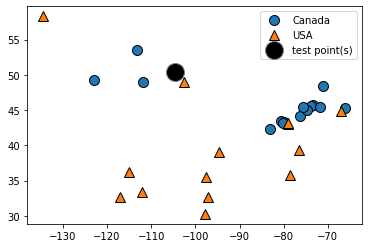

In [25]:
plot_train_test_points(
    X_small_cities,
    y_small_cities,
    test_point,
    class_names=["Canada", "USA"],
    test_format="circle",
)

- Given a new data point, predict the class of the data point by finding the "closest" data point in the training set, i.e., by finding its "nearest neighbour" or majority vote of nearest neighbours. 

Suppose we want to predict the class of the black point.  
- An intuitive way to do this is predict the same label as the "closest" point ($k = 1$) (1-nearest neighbour)
- We would predict a target of **USA** in this case.

n_neighbors 1


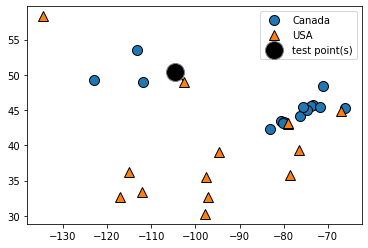

In [26]:
plot_knn_clf(
    X_small_cities,
    y_small_cities,
    test_point,
    n_neighbors=1,
    class_names=["Canada", "USA"],
    test_format="circle",
)

How about using $k > 1$ to get a more robust estimate? 
- For example, we could also use the 3 closest points (*k* = 3) and let them **vote** on the correct class.  
- The **Canada** class would win in this case. 

n_neighbors 3


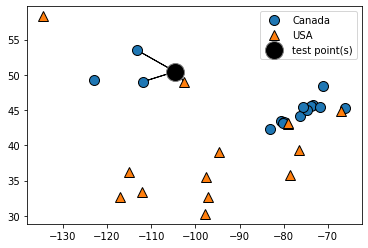

In [27]:
plot_knn_clf(
    X_small_cities,
    y_small_cities,
    test_point,
    n_neighbors=3,
    class_names=["Canada", "USA"],
    test_format="circle",
)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 3, 5, 7]

for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_small_cities, y_small_cities)
    print(
        "Prediction of the black dot with %d neighbours: %s"
        % (k, neigh.predict(test_point))
    )

Prediction of the black dot with 1 neighbours: ['USA']
Prediction of the black dot with 3 neighbours: ['Canada']
Prediction of the black dot with 5 neighbours: ['USA']
Prediction of the black dot with 7 neighbours: ['USA']


### Questions

- Is it a good or a bad idea to consider an odd number for $k$? Why or why not? 
- Try different values of $k$ in the above code. 

### Choosing `n_neighbors`

- The primary hyperparameter of the model is `n_neighbors` ($k$) which decides how many neighbours should vote during prediction? 
- What happens when we play around with `n_neighbors`?
- Are we more likely to overfit with a low `n_neighbors` or a high `n_neighbors`?
- Let's examine the effect of the hyperparameter on our cities data. 

In [29]:
X = cities_df.drop(columns=["country"])
y = cities_df["country"]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123
)

In [30]:
k = 1
knn1 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn1, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000000,0.008006,0.710526,1.0
1,0.000000,0.000000,0.684211,1.0
2,0.000000,0.007996,0.842105,1.0
3,0.007996,0.000000,0.702703,1.0
4,0.000000,0.000000,0.837838,1.0


In [31]:
k = 100
knn100 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn100, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000000,0.000000,0.605263,0.600000
1,0.008003,0.007986,0.605263,0.600000
2,0.007994,0.000000,0.605263,0.600000
3,0.000000,0.008055,0.594595,0.602649
4,0.000000,0.000000,0.594595,0.602649


In [32]:
def f(n_neighbors=1):
    results = {}
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results["n_neighbours"] = [n_neighbors]
    results["mean_train_score"] = [round(scores["train_score"].mean(), 3)]
    results["mean_valid_score"] = [round(scores["test_score"].mean(), 3)]
    print(pd.DataFrame(results))


interactive(
    f,
    n_neighbors=widgets.IntSlider(min=1, max=101, step=10, value=1),
)

interactive(children=(IntSlider(value=1, description='n_neighbors', max=101, min=1, step=10), Output()), _dom_…

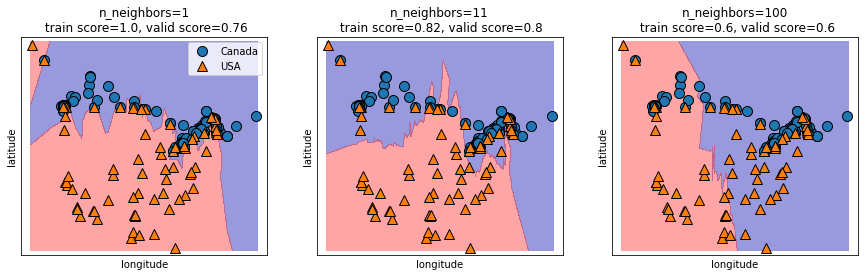

In [33]:
plot_knn_decision_boundaries(X_train, y_train, k_values=[1, 11, 100])

### How to choose `n_neighbors`?

- `n_neighbors` is a hyperparameter
- We can use hyperparameter optimization to choose `n_neighbors`.

In [34]:
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(1, 50, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)

In [35]:
results_df = results_df.set_index("n_neighbors")
results_df

,mean_train_score,mean_cv_score,std_cv_score,std_train_score
n_neighbors,,,,
1,1.000000,0.755477,0.069530,0.000000
6,0.831135,0.792603,0.046020,0.013433
11,0.819152,0.802987,0.041129,0.011336
16,0.801863,0.782219,0.074141,0.008735
21,0.777934,0.766430,0.062792,0.016944
26,0.755364,0.723613,0.061937,0.025910
31,0.743391,0.707681,0.057646,0.030408
36,0.728777,0.707681,0.064452,0.021305
41,0.706128,0.681223,0.061241,0.018310


<AxesSubplot:xlabel='n_neighbors'>

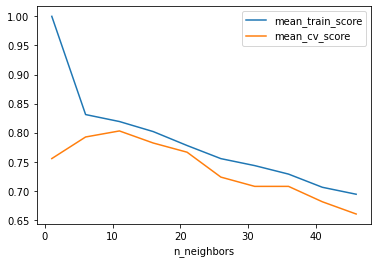

In [44]:
results_df[["mean_train_score", "mean_cv_score"]].plot()

In [45]:
best_n_neighbours = results_df.idxmax()["mean_cv_score"]
best_n_neighbours

11

Let's try our best model on test data. 

In [46]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbours)
knn.fit(X_train, y_train)
print("Test accuracy: %0.3f" % (knn.score(X_test, y_test)))

Test accuracy: 0.580


### Questions on distances and $k$-NNs

#### Exercise 4.1

```{admonition} Exercise 4.1: True or False
1. Analogy-based models find examples from the test set that are most similar to the query example we are predicting.
2. A dataset with 10 dimensions is considered low dimensional.
3. Euclidean distance will always have a positive value.
```    

#### Exercise 4.2

What would be the Euclidean distance between the following two vectors `u` and `v`? 

In [47]:
u = np.array([0, 0, 20, -2])
v = np.array([-1, 0, 18, -4])

#### Exercise 4.3

```{admonition} Exercise 4.3: True or False
1. Unlike with decision trees, with $k$-NNs most of the work is done at the `predict` stage. 
2. With $k$-NN, setting the hyperparameter $k$ to larger values typically reduces training error. 
3. Similar to decision trees, $k$-NNs finds a small set of good features.
4. In $k$-NN, the classification of the closest neighbour to the test example always contributes the most to the prediction.
```    

#### Exercise 4.4 $k$-NN practice questions

1. When we calculated Euclidean distances from all cities to all other cities, why did we set the diagonal entries to infinity before finding the closest city?
2. Consider this toy dataset:

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

- If $k=1$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$?
- If $k=3$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$?

<br><br>

## More on $k$-NNs

### Other useful arguments of `KNeighborsClassifier`

- `weights` $\rightarrow$ When predicting label, you can assign higher weight to the examples which are closer to the query example.  
- Exercise for you: Play around with this argument. Do you get a better validation score? 

### (Optional) Regression with $k$-nearest neighbours ($k$-NNs)

- Can we solve regression problems with $k$-nearest neighbours algorithm? 
- In $k$-NN regression we take the average of the $k$-nearest neighbours. 
- We can also have weighted regression. 

See an example of regression in the lecture notes. 

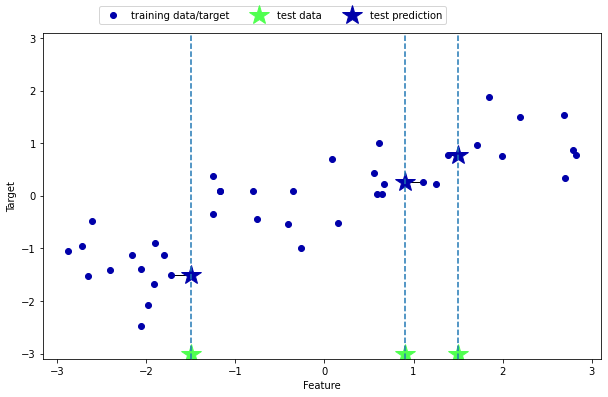

In [48]:
mglearn.plots.plot_knn_regression(n_neighbors=1)

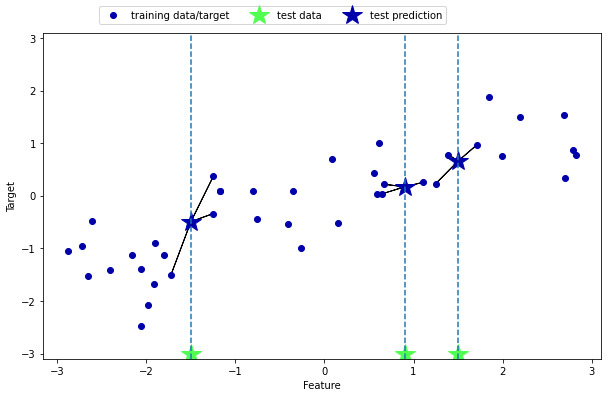

In [49]:
mglearn.plots.plot_knn_regression(n_neighbors=3)

### Pros of $k$-NNs for supervised learning

- Easy to understand, interpret.
- Simple hyperparameter $k$ (`n_neighbors`) controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.
- Lazy learning: Takes no time to `fit`

### Cons of $k$-NNs for supervised learning

- Can be potentially be VERY slow during prediction time, especially when the training set is very large. 
- Often not that great test accuracy compared to the modern approaches.
- It does not work well on datasets with many features or where most feature values are 0 most of the time (sparse datasets).    

For regular $k$-NN for supervised learning (not with sparse matrices), you should **standardize** your features.

### Parametric vs non parametric 

- You might see a lot of definitions of these terms.
- A simple way to think about this is: 
    - do you need to store at least $O(n)$ worth of stuff to make predictions? If so, it's non-parametric.
- Non-parametric example: $k$-NN is a classic example of non-parametric models.     
- Parametric example: decision stump
- If you want to know more about this, find some reading material [here](https://www.cs.ubc.ca/~schmidtm/Courses/340-F16/L6.pdf), [here](http://mlss.tuebingen.mpg.de/2015/slides/ghahramani/gp-neural-nets15.pdf), and [here](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/). 
- By the way, the terms "parametric" and "non-paramteric" are often used differently by statisticians, see [here](https://help.xlstat.com/s/article/what-is-the-difference-between-a-parametric-and-a-nonparametric-test?language=en_US) for more...

### Curse of dimensionality

- Affects all learners but especially bad for nearest-neighbour. 
- $k$-NN usually works well when the number of dimensions $d$ is small but things fall apart quickly as $d$ goes up.
- If there are many irrelevant attributes, $k$-NN is hopelessly confused because all of them contribute to finding similarity between examples. 
- With enough irrelevant attributes the accidental similarity swamps out meaningful similarity and $k$-NN is no better than random guessing.  

In [50]:
from sklearn.datasets import make_classification

nfeats_accuracy = {"nfeats": [], "dummy_valid_accuracy": [], "KNN_valid_accuracy": []}
for n_feats in range(4, 2000, 100):
    X, y = make_classification(n_samples=2000, n_features=n_feats, n_classes=2)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )
    dummy = DummyClassifier(strategy="most_frequent")
    dummy_scores = cross_validate(dummy, X_train, y_train, return_train_score=True)

    knn = KNeighborsClassifier()
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    nfeats_accuracy["nfeats"].append(n_feats)
    nfeats_accuracy["KNN_valid_accuracy"].append(np.mean(scores["test_score"]))
    nfeats_accuracy["dummy_valid_accuracy"].append(np.mean(dummy_scores["test_score"]))

In [51]:
pd.DataFrame(nfeats_accuracy)

,nfeats,dummy_valid_accuracy,KNN_valid_accuracy
0,4,0.501875,0.980625
1,104,0.501875,0.739375
2,204,0.502500,0.636875
3,304,0.505625,0.710000
4,404,0.503750,0.636250
5,504,0.503125,0.672500
6,604,0.502500,0.599375
7,704,0.501875,0.615000
8,804,0.505625,0.618125
9,904,0.500000,0.600000


<br><br>

## Summary

- We have KNNs as a new supervised learning technique in our toolbox.
- These are analogy-based learners and the idea is to assign nearby points the same label.
- Unlike decision trees, all features are equally important. 
- Both can be used for classification or regression (much like the other methods we've seen).

### Coming up:

Lingering questions: 
- Are we ready to do machine learning on real-world datasets?
- What would happen if we use decision tree and  $k$-NNs on the spotify dataset from hw1?  
- What happens if we have missing values in our data? 
- What do we do if we have features with categories or string values?
